In [3]:
from UDR.udr import optimize_udr_policy, train_test_ppo_with_udr
from PPO.ppo_test import train_and_test_policy

n_episodes = 20000
mean_timestep = 300
target_env = "CustomHopper-target-v0"
source_env = "CustomHopper-source-v0"
base_output_folder = "./udr_output"

# optimized for PPO without UDR in source environment
clip_range = 0.219204216258128

print("*** PPO without UDR ***")
train_and_test_policy(
    train_env=source_env,
    test_env=target_env,
    output_folder=f"./{base_output_folder}/no-udr/",
    clip_range=clip_range,
    episodes=n_episodes,
    timesteps=mean_timestep,
    print_std_deviation=True
)

deltas = [0.2, 0.5, 0.8]
for delta in deltas:
    print(f"\n*** PPO with UDR delta: {delta} ***")
    output_folder = f"{base_output_folder}/{delta}"

    clip_range = optimize_udr_policy(delta)
    print(f"Optimized clip range: {clip_range}")

    train_test_ppo_with_udr(
		output_folder=output_folder,
		train_env=source_env,
		test_env=target_env,
		episodes=n_episodes,
		clip_range=clip_range,
		timesteps=mean_timestep,
		delta=delta,
		print_std_deviation=True
	)

*** PPO without UDR ***


/opt/miniconda3/envs/mldl_m4/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean episode length
390.8275906988862
mean train reward
1380.0946752921432


[I 2025-05-28 09:17:29,686] A new study created in memory with name: no-name-2eb1d103-948a-4fe3-af96-788097de154e


mean test reward
980.1480419316008
test rewards file: ././udr_output/no-udr//test_rewards_CustomHopper-target-v0.txt
mean test std
163.35463214574847

*** PPO with UDR delta: 0.2 ***


[I 2025-05-28 10:43:05,424] Trial 2 finished with value: 1498.2646030914784 and parameters: {'clip_range': 0.28980595964610517}. Best is trial 2 with value: 1498.2646030914784.
[I 2025-05-28 10:43:48,337] Trial 1 finished with value: 1619.848229958415 and parameters: {'clip_range': 0.16086448949980608}. Best is trial 1 with value: 1619.848229958415.
[I 2025-05-28 10:44:19,945] Trial 3 finished with value: 1753.643822595358 and parameters: {'clip_range': 0.0351703090535707}. Best is trial 3 with value: 1753.643822595358.
[I 2025-05-28 10:44:37,814] Trial 0 finished with value: 1671.6140869073868 and parameters: {'clip_range': 0.01197246517843818}. Best is trial 3 with value: 1753.643822595358.
[I 2025-05-28 13:17:02,345] Trial 4 finished with value: 1652.643497077346 and parameters: {'clip_range': 0.01630005696449781}. Best is trial 3 with value: 1753.643822595358.
[I 2025-05-28 13:17:06,741] Trial 6 finished with value: 1664.351031473875 and parameters: {'clip_range': 0.031630296720672

Optimized clip range: 0.06962770607449137
mean episode length
348.2870907824472
mean train reward
1290.3049996972297


[I 2025-05-28 14:43:56,283] A new study created in memory with name: no-name-165cf028-2247-43b7-9d18-e891500e51f1


mean test reward
772.7660277292513
test rewards file: ./udr_output/0.2/test_rewards_CustomHopper-target-v0.txt
mean test std
24.494288982518185

*** PPO with UDR delta: 0.5 ***


[I 2025-05-28 16:17:36,340] Trial 0 finished with value: 1535.8253378572465 and parameters: {'clip_range': 0.2616181458283789}. Best is trial 0 with value: 1535.8253378572465.
[I 2025-05-28 16:18:45,895] Trial 3 finished with value: 1592.424977889657 and parameters: {'clip_range': 0.01067334704653719}. Best is trial 3 with value: 1592.424977889657.
[I 2025-05-28 16:18:52,970] Trial 2 finished with value: 1683.7059281077386 and parameters: {'clip_range': 0.023042648319323844}. Best is trial 2 with value: 1683.7059281077386.
[I 2025-05-28 16:19:25,254] Trial 1 finished with value: 1779.9052593262195 and parameters: {'clip_range': 0.05257434102710912}. Best is trial 1 with value: 1779.9052593262195.
[I 2025-05-28 23:14:01,113] Trial 5 finished with value: 996.9953254278898 and parameters: {'clip_range': 0.09731931082966133}. Best is trial 1 with value: 1779.9052593262195.
[I 2025-05-28 23:14:34,953] Trial 4 finished with value: 1254.8893459586502 and parameters: {'clip_range': 0.025125927

Optimized clip range: 0.04379788124882578
mean episode length
357.0043431699191
mean train reward
1265.7896195509118


[I 2025-05-29 00:42:11,941] A new study created in memory with name: no-name-2e45ff6f-8d2b-4cb8-9c9f-42139a73d6f0


mean test reward
979.2931947219953
test rewards file: ./udr_output/0.5/test_rewards_CustomHopper-target-v0.txt
mean test std
32.60521512702376

*** PPO with UDR delta: 0.8 ***


[I 2025-05-29 02:07:27,836] Trial 2 finished with value: 1528.294375856936 and parameters: {'clip_range': 0.13686399431453106}. Best is trial 2 with value: 1528.294375856936.
[I 2025-05-29 02:08:11,286] Trial 1 finished with value: 1724.5446464731097 and parameters: {'clip_range': 0.16718932680293358}. Best is trial 1 with value: 1724.5446464731097.
[I 2025-05-29 02:08:17,006] Trial 3 finished with value: 1753.4510956340432 and parameters: {'clip_range': 0.0982959917336223}. Best is trial 3 with value: 1753.4510956340432.
[I 2025-05-29 02:08:29,841] Trial 0 finished with value: 1773.8136626778246 and parameters: {'clip_range': 0.14739598134479656}. Best is trial 0 with value: 1773.8136626778246.
[I 2025-05-29 03:32:37,476] Trial 4 finished with value: 1232.0887852216958 and parameters: {'clip_range': 0.18507195839476745}. Best is trial 0 with value: 1773.8136626778246.
[I 2025-05-29 03:33:35,158] Trial 7 finished with value: 1323.2095604115725 and parameters: {'clip_range': 0.127403996

Optimized clip range: 0.10391518070485838
mean episode length
323.61336425412577
mean train reward
1142.8871599032336
mean test reward
1068.6041874206653
test rewards file: ./udr_output/0.8/test_rewards_CustomHopper-target-v0.txt
mean test std
70.46761166173285


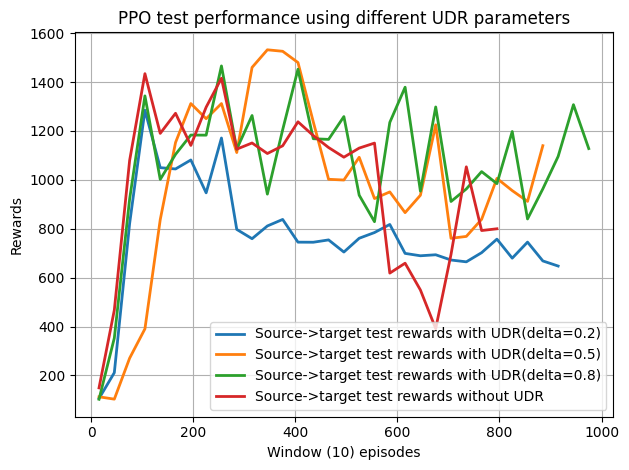

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def get_rewards (filename, window_size: int = 30):
    with open(filename, 'r') as f:
        lines = f.readlines()
        data = [float(line.strip()) for line in lines]

        means = []
        positions = []
        for i in range(0, len(data), window_size):
            window = data[i:i+window_size]
            mean_value = np.mean(window)
            means.append(mean_value)
            positions.append(i + window_size//2)
        
        return means, positions
    
path_test_resources = './trained-models/udr'

for delta in deltas:
    r, p = get_rewards(f"{path_test_resources}/{delta}/test_rewards_CustomHopper-target-v0.txt")
    plt.plot(p, r, label=f'Source->target test rewards with UDR(delta={delta})', linewidth=2)


s_t_test_rewards, st_positions = get_rewards(f'{path_test_resources}/no-udr/test_rewards_CustomHopper-target-v0.txt')
plt.plot(st_positions, s_t_test_rewards, label=f'Source->target test rewards without UDR', linewidth=2)

plt.ylabel("Rewards")
plt.xlabel(f"Window ({10}) episodes")
plt.title("PPO test performance using different UDR parameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()